<h1>Momentum Flux Analysis</h1>

In [19]:
import pysftp
import os 
import numpy as np
import pandas as pd
import netCDF4
import numpy as np

from scipy import io
from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard,data_wizard
from dotenv import load_dotenv   #for python-dotenv method
from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'

ssw_list = [datetime.strptime(file_name[:10], '%Y-%m-%d') for file_name in os.listdir('ssw_events_saved_filtered_2/')]
ssw_list.sort()

In [34]:
grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()
# Select coordinates of interest
select_area_indexer = grid.select_area_indexer(min_lat= 58,max_lat= 62,min_lon= -180,max_lon= 180)

def generate_dataset(path = 'processed_airs_sftp/mfy/', col_names ='col_name'):
    # path: path to the folder containing the npz files
    # col_names: name of the column in the dataframe
    date_col = []
    data_mean_col = []
    for file in os.listdir(path):
        # print(file)
        if file != ".DS_Store":
            data = np.load(path + file, allow_pickle=True)['arr_0']
            if col_names == 'mfx':
                # calculate cosine of latitudes
                cos_lat = np.cos(np.deg2rad(grid.nh_lat))
                data = data * cos_lat

            # select only the right coordinates using the wizard
            data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = data)
            # calculate the mean of the data
            data_mean = np.nanmean(data)

            file_date = file[:10]
            date_col.append(file_date)
            data_mean_col.append(data_mean)

    df = pd.DataFrame(data={'dates' : date_col,f'{col_names}_mean' : data_mean_col})
    # add description of the data
    df['dates'] = pd.to_datetime(df['dates'])
    df = df.sort_values(by='dates')
    df = df.reset_index()
    df = df.drop(columns=['index'])
    df['year'] = df['dates'].apply(lambda x: x.year)

    return df, data

df_mfy, last_data = generate_dataset(path = 'processed_airs_sftp/40_km_grid/30km/mfx/',col_names='mfx')
df_mfx, last_data = generate_dataset(path = 'processed_airs_sftp/40_km_grid/30km/mfy/',col_names='mfy')


/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_5781/2087442977.py:23: RuntimeWarning:

Mean of empty slice

/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_5781/2087442977.py:23: RuntimeWarning:

Mean of empty slice



/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_5781/789447041.py:24: UserWarning:

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


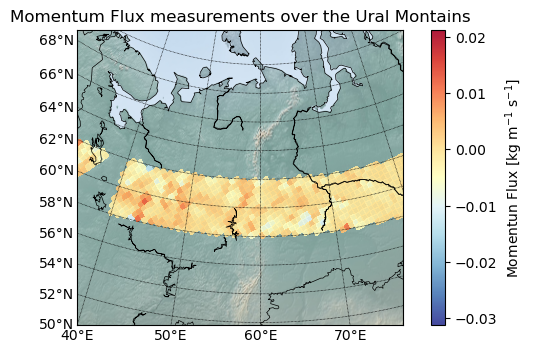

In [35]:
# Momentum Flux over Moountain Areas - Urals (use geo_plotting env)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
grid = map_grid(grid_size='40', source='airs')
# calculate cos of the latitudes
cos_lat = np.deg2rad(grid.nh_lat)
data = last_data * cos_lat
wizard = data_wizard()

fig = plt.figure(figsize=(7, 5))

m = Basemap(projection='stere', lon_0=60, lat_0=60, llcrnrlat=50, urcrnrlat=70,
            llcrnrlon=40, urcrnrlon=90, resolution='l')

m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawparallels(np.arange(50, 71, 2), linewidth=0.5, labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(40, 91, 10), linewidth=0.5, labels=[0, 0, 0, 1])

x, y = m(grid.nh_lon, grid.nh_lat)
m.pcolormesh(x, y, data, cmap='RdYlBu_r', shading='auto', alpha=0.9)
m.etopo(alpha=0.5)

m.shadedrelief(scale=0.5)

plt.colorbar(label='Momentun Flux [kg m$^{-1}$ s$^{-1}$]')
plt.title('Momentum Flux measurements over the Ural Montains')
# move title up a bit
plt.subplots_adjust(top=0.7)
# make labels smaller
ax = plt.gca()
plt.show()


In [38]:
# merge df_mfx and df_mfy on dates, keep all columns that are the same (do not create aliases)
df_merged = pd.merge(df_mfx, df_mfy, on='dates', how='outer', suffixes=('', '_y'))

# df_merged[['mfy_data_mean']] = df_merged[['mfy_data_mean']] * np.cos(np.deg2rad(60))
df_merged['dayofyear'] = df_merged['dates'].dt.dayofyear
# multiply square root of the columns mfx_data_mean squared and mfy_data_mean squared in the df_all dataframe
df_merged['mf_abs'] = np.sqrt(df_merged['mfx_mean']**2 + df_merged['mfy_mean']**2)

df_merged = df_merged.drop(columns=['year_y'])

In [39]:
df_merged

,dates,mfy_mean,year,mfx_mean,dayofyear,mf_abs
0,2002-08-31,-0.000164,2002,-0.000006,243,0.000164
1,2002-09-01,-0.000069,2002,0.000012,244,0.000070
2,2002-09-02,-0.000100,2002,-0.000014,245,0.000101
3,2002-09-03,-0.000139,2002,-0.000008,246,0.000139
4,2002-09-04,-0.000141,2002,0.000011,247,0.000141
...,...,...,...,...,...,...
6263,2019-12-27,-0.004754,2019,-0.023653,361,0.024126
6264,2019-12-28,-0.008208,2019,-0.023249,362,0.024656
6265,2019-12-29,-0.006295,2019,-0.024119,363,0.024927
6266,2019-12-30,-0.016155,2019,-0.023182,364,0.028256


In [40]:
# save df_merged to csv file
df_merged.to_csv('mfx_dataframe.csv', index=False)

In [41]:
df_merged

,dates,mfy_mean,year,mfx_mean,dayofyear,mf_abs
0,2002-08-31,-0.000164,2002,-0.000006,243,0.000164
1,2002-09-01,-0.000069,2002,0.000012,244,0.000070
2,2002-09-02,-0.000100,2002,-0.000014,245,0.000101
3,2002-09-03,-0.000139,2002,-0.000008,246,0.000139
4,2002-09-04,-0.000141,2002,0.000011,247,0.000141
...,...,...,...,...,...,...
6263,2019-12-27,-0.004754,2019,-0.023653,361,0.024126
6264,2019-12-28,-0.008208,2019,-0.023249,362,0.024656
6265,2019-12-29,-0.006295,2019,-0.024119,363,0.024927
6266,2019-12-30,-0.016155,2019,-0.023182,364,0.028256


In [27]:
import plotly.graph_objects as go
df_all  = df_merged

fig = go.Figure()
fig.add_shape(type='line', x0=df_all['dates'].min(), y0=0, x1=df_all['dates'].max(), y1=0, line=dict(color='gray', dash='dash'))

for year, df in df_all.groupby('year'):
    fig.add_trace(go.Scatter(x=df['dayofyear'], y=df['mfx_data_mean'], name=f'{year}', line=dict()))

    # Set layout for each year
    fig.update_layout(
        yaxis=dict(
            range=[-0.002, 0.0005]),
        xaxis=dict(title='Dates'),
        title=f'Momentum Flux (x) in listed years',
        legend=dict(orientation="h", y=1.2, x=0.5)
    )

    # Show the plot for each year
fig.show()

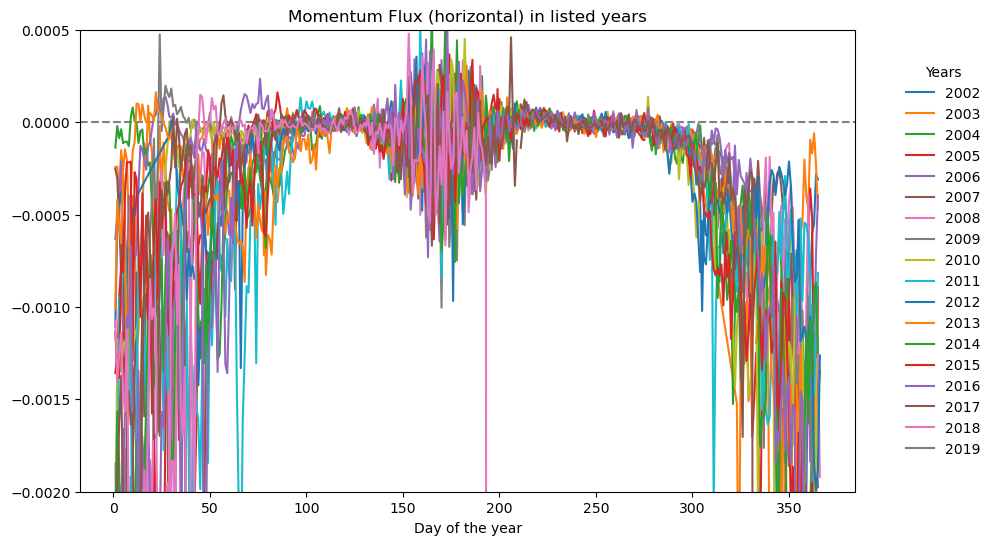

In [28]:
import matplotlib.pyplot as plt

df_all = df_merged

# create a new figure with a larger size
fig = plt.figure(figsize=(10, 6))

# create a dashed line at y=0
plt.axhline(y=0, color='gray', linestyle='--')

for year, df in df_all.groupby('year'):
    plt.plot(df['dayofyear'], df['mfx_data_mean'], label=f'{year}')

# set layout for the entire plot
plt.ylim(-0.002, 0.0005)
plt.xlabel('Day of the year')
plt.title(f'Momentum Flux (horizontal) in listed years')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='Years', ncol=1, frameon=False)

# add all labels vertically to the right


# show the entire plot
plt.show()
